In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matrix_completion import svt_solve, calc_unobserved_rmse, nuclear_norm_solve
import ipdb
import logging
import random
import scipy
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import autoreload
import time
from cvxpy import *
import seaborn as sns
import copy
import re

logging.basicConfig(level=logging.INFO)
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style('darkgrid')

In [4]:
sys.path.append("./utils/")

In [6]:
#Configurations for the script
_users_range = 100
_movie_range = 23
_T = 10

# Controls how quickly the submodular regularization plateaus off
# In a practical application, this would be a really important hyperparameter
_lambda_one = 1
_lambda_two = 20e-5

# For matrix completion
_mu = 1e-3

#The variance of the noise in the rewards during the algorithm
_sigma = 0.001

# For the Laplacian non-sparsification
_decay_rate = 5

_num_meta_users = 1

#For the tradeoff between the cosine, jaccard and linear kernel when designing the composite kernel
_k1 = 1 
_k2 = 1
_k3 = 0

"""
The plots are looking quite good with this choice.
It may be of interest to decay or make it grow, but I don't see a strong reason for either.
"""
_beta_lst = [0.01 for i in range(_T)]
#_beta_lst = [2 + (np.log((i+1)/0.1))**3 for i in range(_T)]
#_beta_lst = 100 * np.array(_beta_lst)

## Load Data

First I load the dataframes

In [7]:
ratings_df = #LOAD pd.read_csv('ratings.csv') data here from movieLens

In [8]:
movies_df = #LOAD pd.read_csv('movies.csv') data here from movieLens

In [9]:
popular_movies_gb = ratings_df.groupby('movieId').size().sort_values(ascending=False)

In [94]:
popular_movies = popular_movies_gb.index.tolist()[30:45]

In [95]:
popular_movies

[3578,
 592,
 588,
 364,
 4306,
 380,
 590,
 58559,
 377,
 4226,
 1580,
 1704,
 79132,
 1240,
 1291]

In [96]:
handpicked_movies_lst = [858, 1221, 2023, 2628, 5378, 33493, 4896, 5816, 79132]
selected_movies_lst = np.unique(handpicked_movies_lst + popular_movies)

In [171]:
_movie_range = len(selected_movies_lst)

In [172]:
_movie_range

23

In [98]:
movies_df_s = movies_df[movies_df["movieId"].isin(selected_movies_lst)]
movies_df_s

,movieId,title,genres
359,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
372,377,Speed (1994),Action|Romance|Thriller
375,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
582,590,Dances with Wolves (1990),Adventure|Drama|Western
584,592,Batman (1989),Action|Crime|Thriller
840,858,"Godfather, The (1972)",Crime|Drama
1190,1221,"Godfather: Part II, The (1974)",Crime|Drama
1207,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller
1258,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure


In [224]:
all_movies = movies_df_s["title"].tolist()

In [138]:
affinity_mat = np.zeros((_movie_range, _movie_range))

godfather_one = movie_to_column[858]
godfather_two = movie_to_column[1221]
godfather_three = movie_to_column[2023]


harry_one = movie_to_column[4896]
harry_two = movie_to_column[5816]

sw_one = movie_to_column[2628]
sw_two = movie_to_column[5378]
sw_three = movie_to_column[33493]

Below, I extract the users that are most represented in the data. This will improve the quality of matrix completion and the ratings matrix that I am using.

In [99]:
ratings_df = ratings_df[ratings_df['movieId'].isin(selected_movies_lst)]

In [100]:
selected_users_gb = ratings_df.groupby('userId').size().sort_values(ascending=False)[:_users_range]
selected_users_lst = selected_users_gb.index.tolist()

In [101]:
selected_users_gb

userId
148409    23
70401     23
93074     23
133040    23
112101    23
          ..
138551    23
40523     23
134638    23
144475    23
79175     23
Length: 100, dtype: int64

In [102]:
ratings_df_s = ratings_df[ratings_df['userId'].isin(selected_users_lst)] 

Create the ratings matrix

In [103]:
user_to_row = dict((e, idx) for (idx, e) in enumerate(selected_users_lst))

In [104]:
movie_to_column = dict((e, idx) for (idx, e) in enumerate(selected_movies_lst))

In [105]:
column_to_movie = dict(enumerate(selected_movies_lst))

In [106]:
M = np.empty((_users_range, _movie_range))
mask = np.zeros((_users_range, _movie_range))

M[:] = 0

In [107]:
for idx, row in ratings_df_s.iterrows():
        user_id, movie_id, rating = int(row["userId"]), int(row["movieId"]), row["rating"]
        row, column = user_to_row[user_id], movie_to_column[movie_id]
        M[row, column] = rating
        mask[row, column] = 1

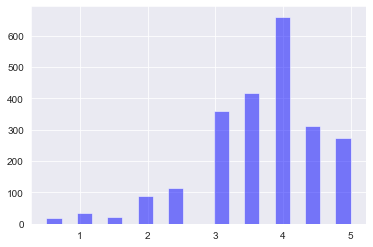

In [108]:
n,bins,patches = plt.hist(np.ravel(M),20,facecolor='blue',alpha=0.5); 
plt.show()

In [150]:
#Sparsity ratio
np.sum(mask)/mask.size

1.0

In [110]:
M.shape

(100, 23)

In [151]:
#plt.imshow(M.T)
M_filled = M

# Create affinity matrix

In [142]:
affinity_mat[:, godfather_one] = 1
affinity_mat[:, harry_one] = 1/2
affinity_mat[:, sw_one] = 1

affinity_mat[godfather_one, godfather_two] = 10
affinity_mat[godfather_two, godfather_three] = 10


affinity_mat[harry_one, harry_two] = 10


affinity_mat[sw_one, sw_two] = 10
affinity_mat[sw_two, sw_three] = 10

In [ ]:
movies_dict = {}

for i in range(_movie_range):
    movie = column_to_movie[i]
    movie_name = movies_df_s[movies_df["movieId"] == movie]["title"].tolist()[0]
    movies_dict[movie_name] = affinity_mat[:, i]

In [149]:
affinity_df = pd.DataFrame(movies_dict)
affinity_df

,"Lion King, The (1994)",Speed (1994),True Lies (1994),Aladdin (1992),Dances with Wolves (1990),Batman (1989),"Godfather, The (1972)","Godfather: Part II, The (1974)","Terminator, The (1984)",Indiana Jones and the Last Crusade (1989),...,Star Wars: Episode I - The Phantom Menace (1999),Gladiator (2000),Memento (2000),Shrek (2001),Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Star Wars: Episode II - Attack of the Clones (2002),Harry Potter and the Chamber of Secrets (2002),Star Wars: Episode III - Revenge of the Sith (2005),"Dark Knight, The (2008)",Inception (2010)
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


## Perform KMeans on Users

In [177]:
#normalized_ratings = np.array([row/np.linalg.norm(row) for row in M_filled])

In [49]:
kmeans = KMeans(n_clusters=_num_meta_users, random_state=0).fit(M_filled)
cluster_centers = kmeans.cluster_centers_
user_labels = kmeans.labels_

In [50]:
user_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## Objective Functions

In [175]:
"""
Online reward evaluation
"""
def compute_affinity_gain(S_i, new_movie, affinity_mat):
    
    #Rows are movies that are already chosen
    affinity_mat_filtered = affinity_mat[S_i]
    
    relevant_column = affinity_mat_filtered[:, new_movie]
    return np.sum(relevant_column)


def compute_facility_location_gain(S_i, new_movie, ratings_mat, running_max_per_user):    
    S_new = copy.deepcopy(S_i)
    S_new.append(new_movie)
    
    new_maxes = np.max(ratings_mat[:, S_new], axis = 1)
    gain = np.sum(new_maxes) - np.sum(running_max_per_user)
    
    return gain, new_maxes


def compute_bp_gain(S_i, new_movie, affinity_mat, ratings_mat, running_max_per_user, lambda_one, mutate = False):
    
    sub_gain, new_maxes = compute_facility_location_gain(S_i, new_movie, ratings_mat, running_max_per_user)
    sup_gain = compute_affinity_gain(S_i, new_movie, affinity_mat)
    
    bp_gain = lambda_one * sup_gain + sub_gain
    
    if mutate :
        return new_maxes, bp_gain
    else:
        return bp_gain

## Environment and Greedy for Simulation

In [185]:
class Environment:

    def __init__(self, T, sigma, lambda_one, ratings_mat, affinity_mat, movies_df_s, 
                  recommender, column_to_movie, seed = 0):
        
        self.T = T
        self.sigma = sigma
        self.lambda_one = lambda_one
        self.ratings_mat = ratings_mat
        self.affinity_mat = affinity_mat
        self.movies_df_s = movies_df_s
        self.recommender = recommender
        self.column_to_movie = column_to_movie
        self.seed = seed

    def run_simulation(self):
        user_range, movie_range = self.ratings_mat.shape

        Si_lst = []
        yi_hist = []
        sub_hist, sup_hist = [], []
        running_max = np.zeros(user_range)

        for i in range(self.T):

            Si = Si_lst

            #Obtain recommendation from recommender
            x_i = self.recommender.get_next_item()

            movie_id = self.column_to_movie[x_i]
            print(self.movies_df_s[self.movies_df_s["movieId"] == movie_id])
            print("\n")
            Si_lst.append(x_i)

            
            sup_gain  = compute_affinity_gain(Si, x_i, self.affinity_mat)
            sub_gain, new_maxes = compute_facility_location_gain(Si, x_i, self.ratings_mat, 
                                                                 running_max)
            running_max = new_maxes
            
            if i > 0:
                sub = sub_hist[-1] + sub_gain
                sup =  sup_hist[-1] + self.lambda_one*sup_gain
            else :
                sub, sup = sub_gain, self.lambda_one*sup_gain


            #Get reward
            y_i = sub_gain + self.lambda_one*sup_gain + self.sigma*np.random.normal()

            #Bookkeeping
            sub_hist.append(sub)
            sup_hist.append(sup)
            yi_hist.append(y_i)

        return Si_lst, yi_hist, sub_hist, sup_hist

In [177]:
class GreedyBaseline:

    def __init__(self, ground_set, column_to_movie, movies_df_s, ratings_mat, affinity_mat, lambda_one):

        #Information about the ground set
        self.ground_set = ground_set
        self.movies_df_s = movies_df_s
        self.ratings_mat = ratings_mat
        self.lambda_one = lambda_one
        self.affinity_mat = affinity_mat

        #Record what is happening in the game
        self.yi_list = []
        self.selected = []
        self.running_max_per_user = np.zeros(len(ratings_mat))
    

    def get_next_item(self):

        potential_gains = []

        for item in self.ground_set:
            if item in self.selected:
                potential_gains.append(0)
                continue
            else :
                gain = compute_bp_gain(self.selected, item, self.affinity_mat, self.ratings_mat, 
                                       self.running_max_per_user, self.lambda_one, mutate = False)
                
                potential_gains.append(gain)
                
        selected_movie = np.argmax(potential_gains)
        self.selected.append(selected_movie)

        gain, running_max = compute_bp_gain(self.selected, selected_movie, self.affinity_mat, self.ratings_mat, 
                                       self.running_max_per_user, self.lambda_one, mutate = True)
        
        self.running_max_per_user = running_max
        return selected_movie

    def receive_reward(self, yi):
        self.yi_list.append(yi)
        return True

## Running the Algorithm 

In [164]:
ground_set = np.arange(_movie_range)

In [200]:
random_rec = RandomBaseline(ground_set, genre_list, movie_similarity_mat, 
                            column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels)

env_random = Environment(_T, _sigma, genre_list, _lambda_one, _lambda_two, 
                  movie_similarity_mat, column_to_movie, M_filled, movies_df_s, cluster_centers, user_labels, random_rec)

ret_random = env_random.run_simulation()

User identity at iteration 0 is: 0
      movieId                title  genres
1225     1258  Shining, The (1980)  Horror


User identity at iteration 1 is: 1
      movieId           title            genres
4122     4226  Memento (2000)  Mystery|Thriller


User identity at iteration 2 is: 0
      movieId                        title        genres
1052     1079  Fish Called Wanda, A (1988)  Comedy|Crime


User identity at iteration 3 is: 1
       movieId                          title       genres
11932    55820  No Country for Old Men (2007)  Crime|Drama


User identity at iteration 4 is: 1
      movieId           title                genres
3930     4034  Traffic (2000)  Crime|Drama|Thriller


User identity at iteration 5 is: 2
      movieId                      title genres
1213     1246  Dead Poets Society (1989)  Drama


User identity at iteration 6 is: 0
      movieId                                             title  \
2537     2628  Star Wars: Episode I - The Phantom Menace (1999

User identity at iteration 60 is: 1
     movieId                     title                              genres
898      919  Wizard of Oz, The (1939)  Adventure|Children|Fantasy|Musical


User identity at iteration 61 is: 2
      movieId                                              title  \
9952    33493  Star Wars: Episode III - Revenge of the Sith (...   

                       genres  
9952  Action|Adventure|Sci-Fi  


User identity at iteration 62 is: 2
      movieId               title                genres
5269     5377  About a Boy (2002)  Comedy|Drama|Romance


User identity at iteration 63 is: 2
       movieId                    title                   genres
12221    58559  Dark Knight, The (2008)  Action|Crime|Drama|IMAX


User identity at iteration 64 is: 0
      movieId             title genres
3918     4022  Cast Away (2000)  Drama


User identity at iteration 65 is: 2
      movieId                    title                                  genres
4742     4848  Mulhollan

User identity at iteration 163 is: 1
      movieId                title                genres
4670     4776  Training Day (2001)  Crime|Drama|Thriller


User identity at iteration 164 is: 1
      movieId              title                            genres
5241     5349  Spider-Man (2002)  Action|Adventure|Sci-Fi|Thriller


User identity at iteration 165 is: 0
      movieId           title                              genres
2893     2985  RoboCop (1987)  Action|Crime|Drama|Sci-Fi|Thriller


User identity at iteration 166 is: 0
      movieId          title                 genres
3907     4011  Snatch (2000)  Comedy|Crime|Thriller


User identity at iteration 167 is: 0
      movieId                                              title  \
1179     1210  Star Wars: Episode VI - Return of the Jedi (1983)   

                       genres  
1179  Action|Adventure|Sci-Fi  


User identity at iteration 168 is: 1
       movieId             title  \
14937    79132  Inception (2010)   

          

In [196]:
greedy_rec = GreedyBaseline(ground_set, column_to_movie, movies_df_s, M_filled, affinity_mat, _lambda_one)


env_greedy = Environment(_T, _sigma, _lambda_one, M_filled, affinity_mat, movies_df_s, 
                  greedy_rec, column_to_movie)

ret_greedy = env_greedy.run_simulation()

     movieId                  title       genres
840      858  Godfather, The (1972)  Crime|Drama


      movieId           title            genres
4122     4226  Memento (2000)  Mystery|Thriller


      movieId                           title       genres
1190     1221  Godfather: Part II, The (1974)  Crime|Drama


       movieId                    title                   genres
12221    58559  Dark Knight, The (2008)  Action|Crime|Drama|IMAX


      movieId                            title                        genres
1934     2023  Godfather: Part III, The (1990)  Crime|Drama|Mystery|Thriller


      movieId                                             title  \
2537     2628  Star Wars: Episode I - The Phantom Menace (1999)   

                       genres  
2537  Action|Adventure|Sci-Fi  


      movieId                                              title  \
5270     5378  Star Wars: Episode II - Attack of the Clones (...   

                            genres  
5270  Action|Advent

In [205]:
column_idxs = ret_greedy[0]
greedy_bp_movies = [column_to_movie[e] for e in column_idxs]
greedy_movie_names = movies_df[movies_df["movieId"].isin(greedy_bp_movies)]["title"].tolist()

In [209]:
greedy_movie_names = [re.sub(r"\([^()]*\)", "", e) for e in greedy_movie_names]
greedy_movie_names

['Godfather, The ',
 'Godfather: Part II, The ',
 'Godfather: Part III, The ',
 'Star Wars: Episode I - The Phantom Menace ',
 'Memento ',
 "Harry Potter and the Sorcerer's Stone  ",
 'Star Wars: Episode II - Attack of the Clones ',
 'Harry Potter and the Chamber of Secrets ',
 'Star Wars: Episode III - Revenge of the Sith ',
 'Dark Knight, The ']

In [211]:
greedy_rec_sm = GreedyBaseline(ground_set, column_to_movie, movies_df_s, M_filled, affinity_mat, 0)


env_greedy_sm = Environment(_T, _sigma, 0, M_filled, affinity_mat, movies_df_s, 
                  greedy_rec_sm, column_to_movie)

ret_greedy_sm = env_greedy_sm.run_simulation()

     movieId                  title       genres
840      858  Godfather, The (1972)  Crime|Drama


      movieId           title            genres
4122     4226  Memento (2000)  Mystery|Thriller


       movieId                    title                   genres
12221    58559  Dark Knight, The (2008)  Action|Crime|Drama|IMAX


       movieId             title  \
14937    79132  Inception (2010)   

                                                genres  
14937  Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX  


      movieId                           title       genres
1190     1221  Godfather: Part II, The (1974)  Crime|Drama


      movieId                   title                  genres
1207     1240  Terminator, The (1984)  Action|Sci-Fi|Thriller


      movieId                                              title  \
4790     4896  Harry Potter and the Sorcerer's Stone (a.k.a. ...   

                          genres  
4790  Adventure|Children|Fantasy  


      movieId             

In [214]:
column_idxs_sm = ret_greedy_sm[0]
greedy_sm_movies = [column_to_movie[e] for e in column_idxs_sm]
greedy_sm_movie_names = movies_df[movies_df["movieId"].isin(greedy_sm_movies)]["title"].tolist()

In [215]:
greedy_sm_movie_names = [re.sub(r"\([^()]*\)", "", e) for e in greedy_sm_movie_names]
greedy_sm_movie_names

['Lion King, The ',
 'Speed ',
 'Godfather, The ',
 'Godfather: Part II, The ',
 'Terminator, The ',
 'Good Will Hunting ',
 'Memento ',
 "Harry Potter and the Sorcerer's Stone  ",
 'Dark Knight, The ',
 'Inception ']

In [222]:
df_dict = {"SM Objective": greedy_sm_movie_names, "BP Objective": greedy_movie_names}
output_df = pd.DataFrame(df_dict)

In [223]:
print(output_df.to_latex())

\begin{tabular}{lll}
\toprule
{} &                             SM Objective &                                   BP Objective \\
\midrule
0 &                          Lion King, The  &                                Godfather, The  \\
1 &                                   Speed  &                       Godfather: Part II, The  \\
2 &                          Godfather, The  &                      Godfather: Part III, The  \\
3 &                 Godfather: Part II, The  &     Star Wars: Episode I - The Phantom Menace  \\
4 &                         Terminator, The  &                                       Memento  \\
5 &                       Good Will Hunting  &        Harry Potter and the Sorcerer's Stone   \\
6 &                                 Memento  &  Star Wars: Episode II - Attack of the Clones  \\
7 &  Harry Potter and the Sorcerer's Stone   &       Harry Potter and the Chamber of Secrets  \\
8 &                        Dark Knight, The  &  Star Wars: Episode III - Revenge of the

In [231]:
all_movies = [re.sub(r"\([^()]*\)", "", e) for e in all_movies]

In [232]:
lst_one = all_movies[:11] + [' ']
lst_two = all_movies[11:]

ground_set_df_dict = {"First batch": lst_one, "Second batch": lst_two}
ground_set_df = pd.DataFrame(ground_set_df_dict)

In [233]:
print(ground_set_df.to_latex(header=False))

\begin{tabular}{lll}
\toprule
0  &                      Lion King, The  &                             Good Will Hunting  \\
1  &                               Speed  &                      Godfather: Part III, The  \\
2  &                           True Lies  &     Star Wars: Episode I - The Phantom Menace  \\
3  &                             Aladdin  &                                     Gladiator  \\
4  &                  Dances with Wolves  &                                       Memento  \\
5  &                              Batman  &                                         Shrek  \\
6  &                      Godfather, The  &        Harry Potter and the Sorcerer's Stone   \\
7  &             Godfather: Part II, The  &  Star Wars: Episode II - Attack of the Clones  \\
8  &                     Terminator, The  &       Harry Potter and the Chamber of Secrets  \\
9  &  Indiana Jones and the Last Crusade  &  Star Wars: Episode III - Revenge of the Sith  \\
10 &                       Men

## Analysing the results

In [193]:
def make_sub_sup_split_plot_v2(ret, title, title_flag):
    Si_dict = ret[0]
    sub_hist = ret[-2]
    sup_hist = ret[-1]
    single_user_movies = Si_dict
    single_sub_hist = sub_hist
    single_sup_hist = sup_hist
    

    plt.plot(np.arange(len(single_sub_hist)), single_sub_hist, '--', label = title + ':submod')
    plt.plot(np.arange(len(single_sup_hist)), single_sup_hist, label = title+ ':supermod')
    if title_flag:
        plt.title(title)
    plt.legend()
    return True

In [10]:
def make_yi_hist_plot(ret, T, title, title_flag):
    yi_hist = ret[2]
    yi_cumul = np.cumsum(yi_hist)
    plt.plot(np.arange(len(yi_cumul)), yi_cumul, label = title)

    if title_flag:
        plt.title(title)
    plt.legend()
    return True

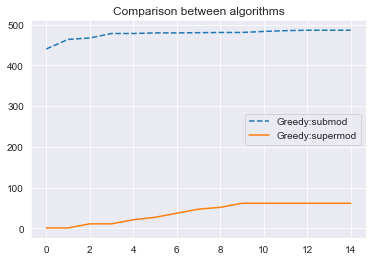

In [194]:
make_sub_sup_split_plot_v2(ret_greedy, "Greedy", False)
plt.title("Comparison between algorithms")
plt.show()